# Cohort Analysis for Online Retail
### What is Cohort Analysis?
Cohort Analysis is to measure user engagement over time. A cohort will be defined and divided based on their common characteristics. This is also a popular analytical technique I used a lot during my work at the ride-hailing company. 

### Input dataset 
The dataset contains all transactions occuring from Jan of 2010 to Dec of 2011 for an online retail. The dataset is downloaded from https://archive.ics.uci.edu/ml/datasets/Online+Retail#. 



In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os

# Set max display rows
pd.set_option('display.max_rows', 500)

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend. figure_format = 'retina'


### Part1 – Import and Preprocess Data

In [2]:
# Import data
df1 = pd.read_excel('../input file/Online Retail History.xlsx')
df1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# check datatype of each field
df = df1.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# check missing data
df = df.dropna(subset=['CustomerID'])
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
# check duplicate data
df = df.drop_duplicates()
df.duplicated().sum()

0

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# Clean the adjustment records that Quantity and UnitPrice is negative
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]

# Calculate Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

### Part2 – Cohort Analysis
#### Definition in this report
> 1. Dataset Period: 2010/12 ~ 2011/12
> 2. Cohort Group: Customers buy products during a certain period of time. Time period in this report is defined as "Month".
> 3. Cohort Index: Nth month to repeat the purchase for a specific cohort, N = 0~12

In [8]:
def extract_month(date):
    year = date.year
    month = date.month
    return datetime(year, month, 1)


In [9]:
def get_cohort_group(dframe):
    cohort_group= []
    dframe['OrderMonth'] = dframe['InvoiceDate'].apply(extract_month)
    
    # Customers having their first purchase behavior in a specific month will be grouped as the same cohort
    cohort_group = dframe.groupby('CustomerID')['OrderMonth']
    cohort_group = cohort_group.transform('min')
    
    return cohort_group

def get_cohort_index(dframe):
    cohort_index = []
    year_diff = dframe['OrderMonth'].dt.year - dframe['CohortMonth'].dt.year
    month_diff = dframe['OrderMonth'].dt.month - dframe['CohortMonth'].dt.month
    cohort_index = year_diff * 12 + month_diff
    
    return cohort_index

def cohort_analysis(dframe):
    data = dframe.copy()
    data['CohortMonth'] = get_cohort_group(data)
    data['CohortIndex'] = get_cohort_index(data)
    
    # Format CohortMonth
    data['CohortMonth'] = data['CohortMonth'].dt.strftime('%Y%m')
    grouping = data.groupby(['CohortMonth', 'CohortIndex'])
    
    # Calculate counts of distinct customers in each cohort
    cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
    
    return cohort_counts

def calculate_retention_rate(dframe):
    data = dframe.copy()
    # Retention rate = counts of customers remain in following cohort index/ counts of new customers in specific cohort
    new_customer_cnt = data.iloc[:,0]
    cohort_rate = data.divide(new_customer_cnt, axis = 0)
    
    return cohort_rate


In [10]:
cohort_counts_table = cohort_analysis(df)
cohort_counts_table

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
201012,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
201101,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
201102,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
201103,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
201104,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
201105,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
201106,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
cohort_retention_table = calculate_retention_rate(cohort_counts_table)
cohort_retention_table

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
201012,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
201101,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
201102,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
201103,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
201104,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
201105,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
201106,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
201107,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


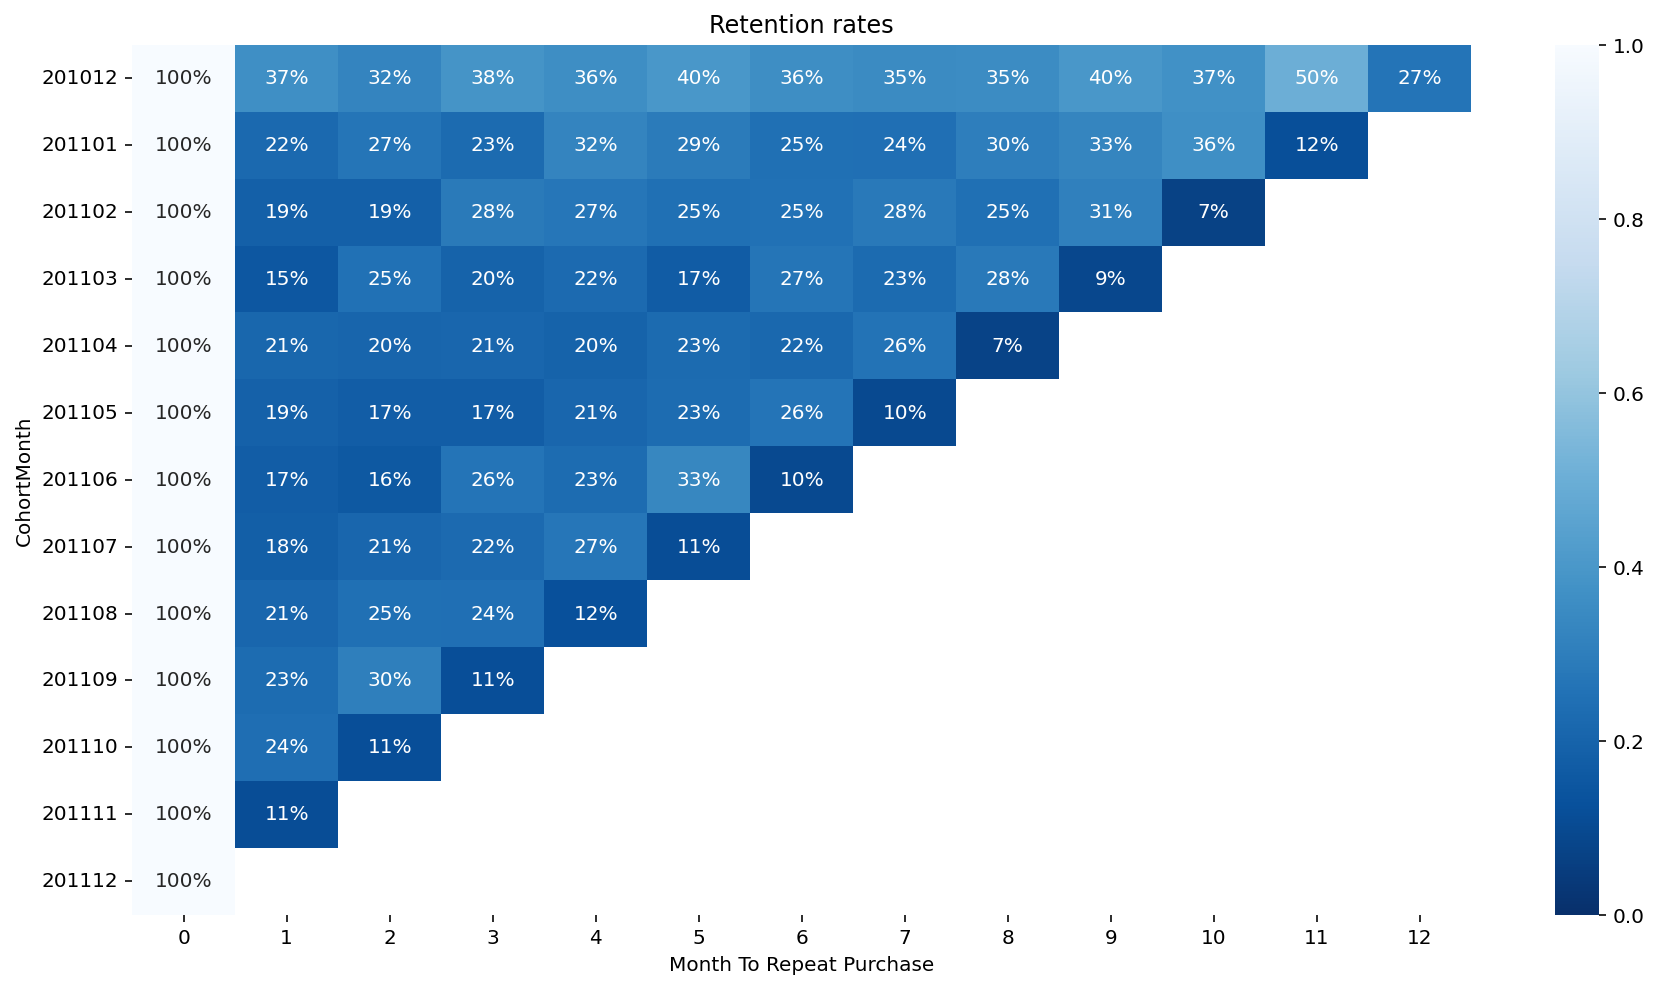

In [12]:
# Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
ax = sns.heatmap(data = cohort_retention_table, annot = True, fmt = '.0%', vmin = 0.0, vmax = 1.0, cmap="Blues_r")
plt.xlabel('Month To Repeat Purchase')
plt.show()

### Reference 

https://www.kaggle.com/code/mahmoudelfahl/cohort-analysis-customer-segmentation-with-rfm/notebook